# Assignment 10: Adversarial Examples & Training

By Joy Rakshit(231681), Geetha Doddapaneni Gopinath (229498), Sri Chandana Hudukula Ram Kumar (231616)

In [24]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

In [38]:
(train_imgs, train_lbls), (test_imgs, test_lbls) = tf.keras.datasets.cifar10.load_data()
train_imgs = train_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
test_imgs = test_imgs.reshape((-1, 32, 32, 3)).astype(np.float32) / 255.
train_lbls = train_lbls.astype(np.int32)[:,0]
test_lbls = test_lbls.astype(np.int32)[:,0]

train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls))
train_data = train_data.shuffle(60000).batch(256).repeat()

test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_lbls)).batch(256)

In [39]:
# build model
tfkl = tf.keras.layers


regularization_factor = 0.00001


def conv_bn_relu(inp, n_filters):
    # use regularizers for weight penalties etc
    # note that the factor needs to be passed here already
    conv = tfkl.Conv2D(n_filters, 3, padding="same", use_bias=False, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(inp)
    # batchnorm is as simple as this.
    # note: convolution has set use_bias=False since it's superfluous if followed
    # by batchnorm directly
    bn = tfkl.BatchNormalization()(conv)
    # spatial dropout is probably a better choice for conv2d
    # NOTE dropout & batch norm don't harmonize well, so probably better to
    # choose one of the two
    return tfkl.SpatialDropout2D(0.2)(tfkl.ReLU()(bn))

def build_model():
    inp = tf.keras.Input((32, 32, 3))

    # best way to do data augmentation: use keras layers
    flipped = tfkl.RandomFlip(mode="horizontal")(inp)
    cropped = tfkl.RandomCrop(30, 30)(flipped)

    l1 = conv_bn_relu(cropped, 32)
    #l1b = conv_bn_relu(l1, 32)
    l1_p = tfkl.MaxPool2D(2, padding="same")(l1)

    l2 = conv_bn_relu(l1_p, 64)
    #l2b = conv_bn_relu(l2, 64)
    l2_p = tfkl.MaxPool2D(2, padding="same")(l2)

    l3 = conv_bn_relu(l2_p, 128)
    #l3b = conv_bn_relu(l3, 128)
    l3_p = tfkl.MaxPool2D(2, padding="same")(l3)

    flat = tfkl.Flatten()(l3_p)
    logits = tfkl.Dense(10, kernel_regularizer=tf.keras.regularizers.L2(regularization_factor))(flat)

    model = tf.keras.Model(inp, logits)
    return model


model = build_model()
train_steps = 10000

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   #(initial_learning_rate, decay_steps, decay_rate)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)


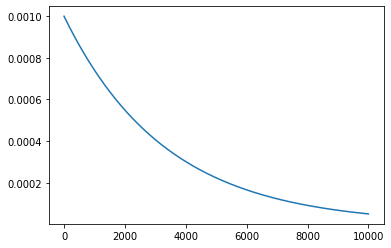

In [40]:
x = tf.range(train_steps)
y = schedule(x)
plt.plot(x, y)

In [41]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # very important to have training=True!!!
        # in this model, this is relevant for dropout, batchnorm, augmentation
        out = model(images, training=True)
        cross_entropy = loss_fn(labels, out)

        # we actually need to add the regularization here!
        # using model.fit, this would be taken care off
        l2_penalty = tf.add_n(model.losses) #add all the input tensors elementwise
        loss = cross_entropy + l2_penalty

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return cross_entropy


def get_test_accuracy():
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    for images, labels in test_data:
        # not training -> set to False. this is also the default if you don't pass it
        accuracy_metric(labels, model(images, training=False))

    return accuracy_metric.result().numpy()

In [6]:
for step, (image_batch, label_batch) in enumerate(train_data):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()


0 3.388418
Test acc 0.1282

500 1.268153
Test acc 0.4623

1000 1.0278075
Test acc 0.6589

1500 1.0590714
Test acc 0.6151

2000 0.93814224
Test acc 0.6705

2500 0.8741601
Test acc 0.6889

3000 0.8672758
Test acc 0.7232

3500 0.74271476
Test acc 0.738

4000 0.73724675
Test acc 0.7334

4500 0.7905084
Test acc 0.7433

5000 0.80514866
Test acc 0.7555

5500 0.7373755
Test acc 0.7523

6000 0.7489584
Test acc 0.7569

6500 0.88751805
Test acc 0.7642

7000 0.67391115
Test acc 0.7627

7500 0.70834494
Test acc 0.7652

8000 0.5673875
Test acc 0.7683

8500 0.77963316
Test acc 0.7717

9000 0.6990833
Test acc 0.7706

9500 0.76395893
Test acc 0.772

10000 0.69850624
Test acc 0.7713



In [29]:
# basic adversarial example setup
# compute gradient of loss with respect to inputs
def run_model(images, labels):
    with tf.GradientTape() as tape:
        tape.watch(images)
        out = model(images, training=False)
        cross_entropy = loss_fn(labels, out)
    gradients = tape.gradient(cross_entropy, images)
    return gradients, cross_entropy, out

In [30]:
gradient_images, loss, predictions = run_model(image_batch, label_batch)
print("Loss on inputs:", loss.numpy())
print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
print("Correct label:", label_batch[0].numpy())
adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 2.2981727
Prediction on 1st input: 0
Correct label: 3


In [31]:
_, loss, predictions = run_model(adversarial_images, label_batch)
print("Loss on adversarial examples:", loss.numpy())
print("Prediction on 1st adversarial input:", np.argmax(predictions[0].numpy()))
print("Groundtruth:", label_batch[0].numpy())

Loss on adversarial examples: 2.3494706
Prediction on 1st adversarial input: 0
Groundtruth: 3


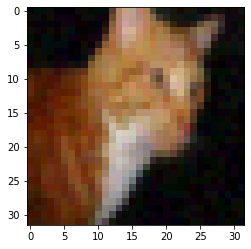

In [32]:
plt.imshow(image_batch[0])

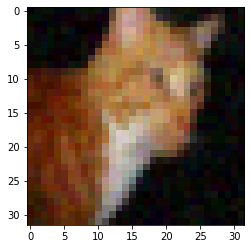

In [33]:
plt.imshow(adversarial_images[0])

Creating adversarial dataset 

In [34]:
# compute gradient of loss with respect to inputs
def create_adversarial(images, labels):
    with tf.GradientTape() as tape:
        tape.watch(images)
        out = model(images, training=False)
        cross_entropy = loss_fn(labels, out)
    gradients = tape.gradient(cross_entropy, images)
    return gradients, cross_entropy, out


###########################################################################

model = build_model()

# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_imgs_adv = tf.data.Dataset.from_tensor_slices((train_imgs, train_lbls)).shuffle(50000).batch(256)

# gradient sign method. you can fiddle with epsilon. the larger, the more dramatic the effect.
# but if it's too large, it doesn't really qualify as an adversarial example anymore!
# clip to between 0 and 1 since adding the gradient might take the images out of that range.
adversarial_images = 0
adversarial_label = 0
for step, (image_batch, label_batch) in enumerate(train_imgs_adv):
    gradient_images, current_loss, predictions = create_adversarial(image_batch, label_batch)

    if step==0:
      adversarial_images = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)
      adversarial_label = label_batch
    else:
      adversarial_images = tf.concat([adversarial_images,tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)],axis=0)
      adversarial_label = tf.concat([adversarial_label, label_batch],axis=0)

    if not step % 50:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()
    



0 2.3027892
Test acc 0.1204

50 2.3031807
Test acc 0.1204

100 2.3027492
Test acc 0.1204

150 2.3081808
Test acc 0.1204



Training with adversarial + original dataset

In [42]:
train_data2 = tf.data.Dataset.from_tensor_slices((tf.concat([adversarial_images[:25000],train_imgs[:25000]],axis=0),
                                               tf.concat([adversarial_label[:25000],train_lbls[:25000]],axis=0))).shuffle(50000).batch(256).repeat()

model = build_model()
# example learning rate schedule
schedule = tf.keras.optimizers.schedules.ExponentialDecay( 0.001, 1, 0.9997)   #(initial_learning_rate, decay_steps, decay_rate)
optimizer = tf.optimizers.Adam(schedule)

loss_fn = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

train_steps = 30000

for step, (image_batch, label_batch) in enumerate(train_data2):
    if step > train_steps:
        break

    current_loss = train_step(image_batch, label_batch)

    if not step % 1500:
        print(step, current_loss.numpy())
        test_accuracy = get_test_accuracy()
        print("Test acc", test_accuracy)
        print()


0 3.6507277
Test acc 0.0952

1500 1.0469744
Test acc 0.6488

3000 0.72916883
Test acc 0.7054

4500 0.76471287
Test acc 0.7283

6000 0.6997071
Test acc 0.7304

7500 0.6383682
Test acc 0.745

9000 0.5951761
Test acc 0.754

10500 0.7708583
Test acc 0.7502

12000 0.67225504
Test acc 0.7518

13500 0.6163271
Test acc 0.7555

15000 0.6437532
Test acc 0.7548

16500 0.6619885
Test acc 0.7558

18000 0.60826397
Test acc 0.7545

19500 0.640708
Test acc 0.7556

21000 0.5088281
Test acc 0.7557

22500 0.73590744
Test acc 0.7553

24000 0.62441355
Test acc 0.7554

25500 0.6891043
Test acc 0.7548

27000 0.61655515
Test acc 0.7549

28500 0.6105192
Test acc 0.7549

30000 0.65881556
Test acc 0.7549



Test adversarial data on newly trained model

In [43]:
for step, (image_batch, label_batch) in enumerate(test_data):
    if step > 0:
        break
    gradient_images, loss, predictions = run_model(image_batch, label_batch)
    print("Loss on inputs:", loss.numpy())
    print("Prediction on 1st input:", np.argmax(predictions[0].numpy()))
    print("Correct label:", label_batch[0].numpy())
    adversarial_images_new = tf.clip_by_value(image_batch + 0.02*tf.math.sign(gradient_images), 0., 1.)

Loss on inputs: 0.74528134
Prediction on 1st input: 3
Correct label: 3


In [44]:
_, loss, predictions = run_model(image_batch, label_batch)
print("Loss on adversarial examples:", loss.numpy())
print("Prediction on 1st adversarial input:", np.argmax(predictions[1].numpy()))
print("Groundtruth:", label_batch[1].numpy())
print()
print("Prediction on 1st adversarial input:", np.argmax(predictions[2].numpy()))
print("Groundtruth:", label_batch[2].numpy())

Loss on adversarial examples: 0.66503465
Prediction on 1st adversarial input: 0
Groundtruth: 0

Prediction on 1st adversarial input: 8
Groundtruth: 0
